In [1]:
# read the network
filepath = 'grafo.graph'
vertices = [];
edges = [];
readVertices = 0;
readEdges = 0;
with open(filepath) as fp:  
    line = fp.readline()
    cnt = 1
    while line:
        #print("Line {}: {}".format(cnt, line.strip()))
        
        if readVertices == 1:
            vertexData = line.strip().split(';');
            if len(vertexData)==4:
                idxGroup = int(vertexData[3]);
                vertices.append([int(vertexData[0]),idxGroup])
                
        if readEdges == 1:
            edgeData = line.strip().split(';');
            if len(edgeData)==2:
                edges.append([int(edgeData[0]),int(edgeData[1])])
                vertices[int(edgeData[0])].append(int(edgeData[1]));

        
        if line.strip() == '# Vertices':
            print('read vertices')
            readVertices = 1;
        if line.strip() == '# Edges':
            readVertices = 0;
            readEdges = 1;
            print('read edge')
        line = fp.readline()
        cnt += 1
        line.strip() 
#print(vertices)
#array con 1 elemento: numero vertice, 2 elemento: grupo que se encuentra
# resto son los vertices con los que se comunica
#print(edges)

read vertices
read edge


Tamaño poblacion
1000
cantidad de pares de comunicacion


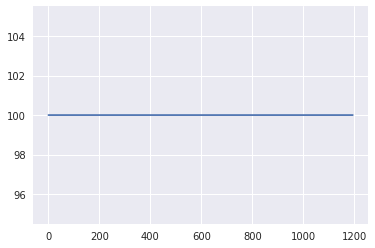

Porcentaje grupos con distinta media de crimen
[0.314 0.359 0.327]
Vector media de crimen por grupos
[0.05 0.   0.5 ]
velocidad de olvido
0.9
impacto de la inseguridad nu
0.9
Resistencia a la inseguridad mu
0.1
Homofilia
0.9466053511705687
Grafica PoS individual


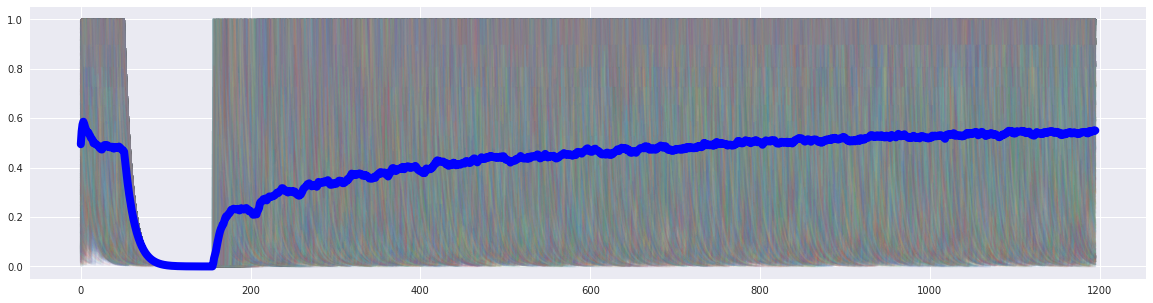

PoS media por grupos


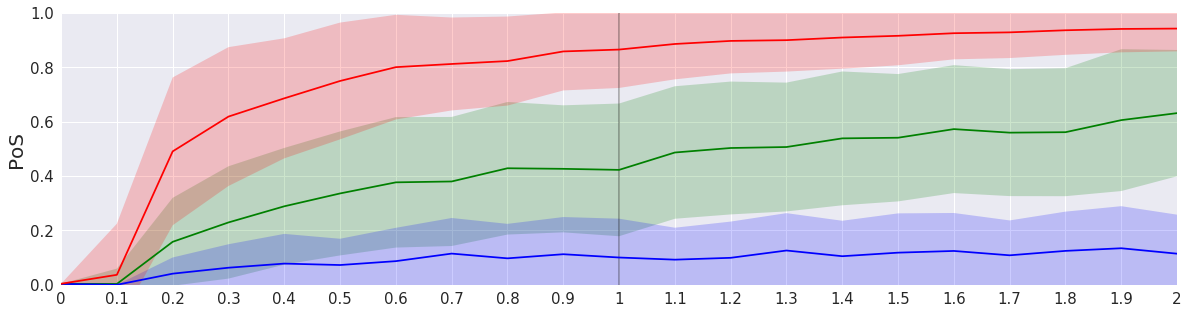

In [4]:
#Simulacion Pos
import numpy as np
import random
import matplotlib.pyplot as plt
n=len(vertices)
#vector identificacion de grupo
goriginal=np.zeros(n)
g=np.zeros(n)
for i in range(n):
    g[i]=vertices[i][1]
# cantidad de grupos
m=int(max(g)+1)
#porcentaje de cada grupo
q=np.zeros(m)
for i in range(m):
    q[i]=sum((g==i)*1.0)/n
#periodos en semanas
annos=23 ##23
T = annos*52  # numero de periodos años x 52 semanas
s = np.random.rand(n)  # vector PoS de las personas en el intante t, al principio aleatorio
psi = 0.9  # velocidad perdida de memoria
nu = 0.9  # Impacto de la inseguridad
mu = 0.1  # Resistencia a la inseguridad
St = np.zeros((T,n ))  # PoS a lo largo del tiempo
lamda = np.array([0.05,0,0.5])  # tasas de crimen de los grupos
#lamda[np.argmax(q)]=0 # para la mayor parte es el grupo inmune
kappa=np.concatenate((np.array([0,0]),np.linspace(0,2,int(T/52)-2)))#comienza en 0 y aumenta hasta 2
#lamda = kappa[0]*lamda  # tasas de crimen de los grupos
#identificacion de cada sujeto con su respectiva media de crimen
for i in range(n):
    for j in range(m):
        if g[i]==j:
            goriginal[i]=lamda[j]
            g[i]=lamda[j]
homofilia=np.zeros(T)
St[0] = s
parescom=np.zeros(T)#cantidad pares de comunicacion en cada periodo
commismogrupo=np.zeros(T)#cantidad de comunicaciones en el mismo grupo
for t in range(1,T):
        #cambio de parametros lamba en el tiempo
        if t%52==0: #al pasar un año cambia k
            for k in range(n):
                g[k]=goriginal[k]*kappa[int(t/52)]
                
        # Al inicio de cada periodo aplicamos la perdida de memoria
        s = psi * s
        
        #escogemos las parejas de comunicacion 
        paleatorio=np.random.permutation(np.arange(n))#personas grupo 1 en orden aleatorio
        persona1=paleatorio[:int(n*0.1)] #primer 10%
        persona2=np.zeros_like(persona1)


        for k in range(len(persona1)):
            #para grupo 1
            aux1=persona1[k]
            aux2=np.random.choice(vertices[aux1][2:])
            contador=0
            while aux2 in persona1 or aux2 in persona2:
                aux2=np.random.choice(vertices[aux1][2:])
                contador=contador+1
                if contador>5:
                        break
            if s[aux1]<s[aux2]:
                s[aux1] = s[aux1] - nu * (s[aux1] - s[aux2])
                s[aux2] = s[aux2] - mu * (s[aux2] - s[aux1])
            else:
                s[aux1] = s[aux1] - mu * (s[aux1] - s[aux2])
                s[aux2] = s[aux2] - nu * (s[aux2] - s[aux1])

            if g[aux1]==g[aux2]:
                commismogrupo[t]=commismogrupo[t]+1
        
        parescom[t]=len(persona1)
        homofilia[t]=commismogrupo[t]/parescom[t]
    

        for k in range(n):
            # numero de crimenes sufridos por la persona k 
            X = np.random.poisson(g[k])
            # posicion hubo crimen o no
            I = 0
            if X >= 1:  # si hubo al menos un crimen I=1 de lo contrario I=0
                I = 1
            # efecto del crimen en la percepcion de k para el siguiente periodo
            s[k] = I + (1 - I) * s[k] 
        St[t] = s
print("Tamaño poblacion")
print(n)
print("cantidad de pares de comunicacion")
plt.plot(parescom[1:])
plt.show()
print("Porcentaje grupos con distinta media de crimen")
print(q)
print("Vector media de crimen por grupos")
print(lamda)
print("velocidad de olvido")
print(psi)
print("impacto de la inseguridad nu")
print(nu)
print("Resistencia a la inseguridad mu")
print(mu)
print("Homofilia")
print(np.mean(homofilia))

%matplotlib inline 
plt.figure(figsize=(20,5))
print("Grafica PoS individual")
plt.plot(St,alpha=0.1)
plt.plot(np.mean(St[:],axis=1),'blue',linewidth=8)
plt.show()
print("PoS media por grupos")
import seaborn as sns
sns.set(color_codes=True)
plt.figure(figsize=(20,5))
colores=['green','blue','red']
plt.axvline(10, color = 'black',alpha=0.3)
plt.xlabel("")
plt.ylabel("PoS",fontsize=20)
ax = plt.axes()
ax.xaxis.set_ticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax.xaxis.set_ticklabels(['0', '0.1', '0.2', '0.3', '0.4','0.5','0.6','0.7','0.8','0.9','1','1.1','1.2','1.3','1.4','1.5','1.6','1.7','1.8','1.9','2'])
ax.tick_params(labelsize=15)
for i in range(m):
    grupo=np.zeros((T,int(n*q[i])))
    contador=0
    for k in range(n):
        if goriginal[k]==lamda[i]:
            grupo[:,contador]=St[:,k]
            contador=contador+1
    #plt.plot(grupo,alpha=0.1)
    sns.tsplot(data=grupo[104::52,:].T,ci='sd',color=colores[i])

plt.ylim(0,1)
#plt.legend(["group 2","group 1", "group 3"],fontsize=20)
plt.savefig('exp2.png')
                